## The Classification Problem

In [94]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier
#import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
#from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import fbeta_score
from uplifting_model.utils import functions as f


In [4]:
df = pd.read_csv('Dataset/bank-full.csv', delimiter=';')
#convert target variable to binary
df['y'] = df['y'].map({'yes': 1, 'no': 0})
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,1
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,1
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,1
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,0


### Data Pre-Proccessing

##### Missing Data

Checking the data for having any N/A values

In [5]:
df.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

Even though the data has no N/A values, it does have some of the categorical values labelled by unknown...I will check their frequency, and accordingly, I will deal with columns where such label is dominant

In [6]:
for column in df.columns:
    if df[column].dtype == 'object':
        print(df[column].value_counts())
        print('\n')


job
blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: count, dtype: int64


marital
married     27214
single      12790
divorced     5207
Name: count, dtype: int64


education
secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: count, dtype: int64


default
no     44396
yes      815
Name: count, dtype: int64


housing
yes    25130
no     20081
Name: count, dtype: int64


loan
no     37967
yes     7244
Name: count, dtype: int64


contact
cellular     29285
unknown      13020
telephone     2906
Name: count, dtype: int64


month
may    13766
jul     6895
aug     6247
jun     5341
nov     3970
apr     2932
feb     2649
jan     1403
oct      738
sep      579
mar      477
dec      214
Name: count, dtype: int64


poutcome
unknown    36959
failure 

The column "poutcome," representing the outcome of the previous marketing campaign, has approximately 90% of values labeled as unknown. Realistically speaking, such data is unattainable. Additionally, the "contact" column, which denotes the contact method used to reach the customer, contains about 30% unknown values. After considering the option of imputing this data, I believe it would be meaningless, as the majority of the non-missing labels are cellular, with only 6% being telephone. Not only is data missing in that column, but the available data is nearly all the same label. Therefore, I will be deleting the two aforementioned columns.

In [7]:
df = df.drop(['contact','poutcome'], axis=1)

##### MultiCollinearity

I will now check if any of the features are highly correlated which may lead to model multicollinearity

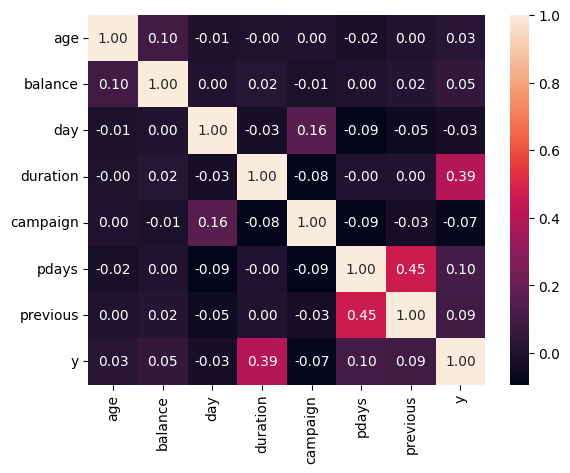

In [8]:
#get all numerical columns
df_num = df.select_dtypes(include=['int64'])
sns.heatmap(df_num.corr(), annot=True, fmt='.2f')
plt.show()


In [9]:
#using the VIF score to check for collinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

df_num = df_num.drop('y', axis=1)
vif_data = pd.DataFrame()
vif_data["Variable"] = df_num.columns
vif_data["VIF"] = [variance_inflation_factor(df_num.values, i) for i in range(len(df_num.columns))]
#find columns with high vif > 4
high_vif_columns = vif_data[(vif_data['VIF'] > 3.5) & np.isfinite(vif_data['VIF'])]['Variable'] 
display(vif_data)

print("Columns with a high VIF score > 3.5: ", high_vif_columns.values)

,Variable,VIF
0,age,5.004058
1,balance,1.212908
2,day,3.984268
3,duration,1.901309
4,campaign,1.824694
5,pdays,1.454202
6,previous,1.341641


Columns with a high VIF score > 3.5:  ['age' 'day']


I was able to find out that the age and day columns both have a VIF score > 3.5, which means that those may both contribute to the multicollinearity of the model. Since, according to the above printed correlation matrix, days hardly has any correlation with the target variable, I will be deleting it and re-running the VIF test to check if the multicollinearity issue would still persist

In [10]:
#using the VIF score to check for collinearity
df_num = df_num.drop('day', axis=1)
vif_data = pd.DataFrame()
vif_data["Variable"] = df_num.columns
vif_data["VIF"] = [variance_inflation_factor(df_num.values, i) for i in range(len(df_num.columns))]
#find columns with high vif > 4
high_vif_columns = vif_data[(vif_data['VIF'] > 3.5) & np.isfinite(vif_data['VIF'])]['Variable'] 
display(vif_data)

print("Columns with a high VIF score > 3.5: ", high_vif_columns.values)

,Variable,VIF
0,age,3.001308
1,balance,1.212681
2,duration,1.885498
3,campaign,1.720985
4,pdays,1.453987
5,previous,1.341515


Columns with a high VIF score > 3.5:  []


All the columns now have a VIF score lower than 3.5, thus I will now go to the next step in data pre-proccessing

##### Categorical Variables

I will now be converting binary categorical variables to 0-1 binary variables, and multi-class categorical variables will be one hot encoded.

In [11]:
#show all categorical columns
df_cat = df.select_dtypes(include=['object'])
df_cat

,job,marital,education,default,housing,loan,month
0,management,married,tertiary,no,yes,no,may
1,technician,single,secondary,no,yes,no,may
2,entrepreneur,married,secondary,no,yes,yes,may
3,blue-collar,married,unknown,no,yes,no,may
4,unknown,single,unknown,no,no,no,may
...,...,...,...,...,...,...,...
45206,technician,married,tertiary,no,no,no,nov
45207,retired,divorced,primary,no,no,no,nov
45208,retired,married,secondary,no,no,no,nov
45209,blue-collar,married,secondary,no,no,no,nov


In [12]:
# convert binary variables to 0 and 1
df['default'] = df['default'].map({'yes': 1, 'no': 0}).astype(int)
df['housing'] = df['housing'].map({'yes': 1, 'no': 0}).astype(int)
df['loan'] = df['loan'].map({'yes': 1, 'no': 0}).astype(int)

#dummify multi-class categorical variables
df = pd.get_dummies(df, columns=['job', 'marital', 'education', 'month'])
df

,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,...,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
0,58,0,2143,1,0,5,261,1,-1,0,...,False,False,False,False,False,False,True,False,False,False
1,44,0,29,1,0,5,151,1,-1,0,...,False,False,False,False,False,False,True,False,False,False
2,33,0,2,1,1,5,76,1,-1,0,...,False,False,False,False,False,False,True,False,False,False
3,47,0,1506,1,0,5,92,1,-1,0,...,False,False,False,False,False,False,True,False,False,False
4,33,0,1,0,0,5,198,1,-1,0,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,0,825,0,0,17,977,3,-1,0,...,False,False,False,False,False,False,False,True,False,False
45207,71,0,1729,0,0,17,456,2,-1,0,...,False,False,False,False,False,False,False,True,False,False
45208,72,0,5715,0,0,17,1127,5,184,3,...,False,False,False,False,False,False,False,True,False,False
45209,57,0,668,0,0,17,508,4,-1,0,...,False,False,False,False,False,False,False,True,False,False


##### Data Leakage

We recognized that the duration column does lead to a data leakage in the model as it presents the duration of the call made with the client, therefore we decided to drop it for the remainder of the classification task.

In [13]:
df = df.drop(['duration'], axis=1)

##### Splitting Data into Training and Test

In [14]:
#split data into training and testing
from sklearn.model_selection import train_test_split
X = df.drop('y', axis=1)
y = df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
training_data = pd.concat([X_train, y_train], axis=1)
testing_data = pd.concat([X_test, y_test], axis=1)

##### Outlier Detection:

I will now work on detecting and eliminating outliers in the data using an isolation forest

In [15]:
##### Outlier Detection:
from sklearn.ensemble import IsolationForest
iforest = IsolationForest(contamination=.05, random_state=0)
pred = iforest.fit_predict(training_data)
# Extracting anomalies
from numpy import where
anomaly_index = where(pred==-1) #-1 is the label for anomalies
anomaly_values = training_data.iloc[anomaly_index]
# Removing anomalies
training_data = training_data.drop(anomaly_values.index)
print("Number of outliers found:", len(anomaly_values))

Number of outliers found: 1809


##### Feature Engineering

I will now employ LASSO regression in an attempt to question the neccesity of having all of the features in the model

In [16]:
from sklearn.linear_model import Lasso

ls = Lasso(alpha=0.01)
X = training_data.drop('y', axis=1)
y = training_data['y']
ls.fit(X, y)
ls.coef_

coef = pd.DataFrame(ls.coef_, index=X.columns, columns=['Coefficient'])
display(coef)

,Coefficient
age,-0.000276
default,-0.000000
balance,0.000003
housing,-0.036238
loan,-0.000000
day,-0.000235
campaign,-0.004762
pdays,0.000050
previous,0.009593
job_admin.,0.000000


I will test the performance of a random forest on the original training features and the LASSO suggested features

In [17]:
#import random forest
from sklearn.ensemble import RandomForestClassifier
#decision tree
from sklearn.metrics import accuracy_score

#train random forest model
rf = RandomForestClassifier(random_state=2)
rf.fit(X, y)
#cross validation
from sklearn.model_selection import cross_val_score
scores = cross_val_score(rf, X, y, cv=5, scoring='accuracy')
print("Cross validation scores of random forest on full feature set :", scores.mean())

#train random forest model on lasso reduced 
Xtraining_data_LASSO = X[coef[coef['Coefficient'] != 0].index]
Xtesting_data_LASSO = X_test[coef[coef['Coefficient'] != 0].index]

rf = RandomForestClassifier(random_state=2)
rf.fit(Xtraining_data_LASSO, y)
#cross val
scores = cross_val_score(rf, Xtraining_data_LASSO, y, cv=5, scoring='accuracy')
print("Cross validation scores of random forest on LASSO reduced feature set :", scores.mean())


Cross validation scores of random forest on full feature set : 0.9045373970572614
Cross validation scores of random forest on LASSO reduced feature set : 0.8990948104169487


As can be seen above, the random forest accuracy with the lasso reduced features does not differ much from the accuracy of the random forest with the all features; in fact, the lasso reduced features random forest performs slightly worse, thus I will keep using the full dataset.

##### Class Imbalance

I will now ensure that the dataset does not have a class imbalance in the target variable

Percentage of the target variable:
y
0    90.389709
1     9.610291
Name: proportion, dtype: float64


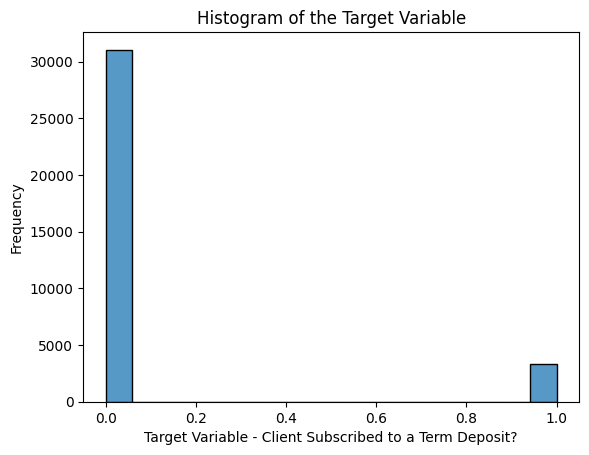

In [18]:
#plot the histogram of the target variable
plt.xlabel('Target Variable - Client Subscribed to a Term Deposit?')
plt.ylabel('Frequency')
plt.title('Histogram of the Target Variable')
sns.histplot(training_data['y'])
print("Percentage of the target variable:")
print(training_data['y'].value_counts(normalize=True) * 100)

There is a clear class imbalance where most of the rows are for instances where the client did not register for a term deposit, and only 9% of the rows represent clients registering for the deposit. Thus, I will be oversampling the minority class, which is clients regestering for a term deposit.

In [19]:

from imblearn.over_sampling import RandomOverSampler

df_copy = training_data.copy()
X = df_copy.drop('y', axis=1)
y = df_copy['y']
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X, y)
df_copy = pd.concat([X_resampled, y_resampled], axis=1)
print(df_copy['y'].value_counts())
df_copy



y
0    31057
1    31057
Name: count, dtype: int64


,age,default,balance,housing,loan,day,campaign,pdays,previous,job_admin.,...,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,y
0,41,0,849,1,0,15,1,-1,0,False,...,False,False,False,False,False,True,False,False,False,0
1,49,0,1415,1,0,30,2,-1,0,False,...,False,False,True,False,False,False,False,False,False,0
2,42,0,3842,0,0,31,4,-1,0,True,...,False,False,True,False,False,False,False,False,False,0
3,37,0,-119,1,0,11,11,-1,0,False,...,False,False,False,True,False,False,False,False,False,0
4,56,0,3498,0,0,15,2,-1,0,False,...,False,False,False,False,False,False,False,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62109,32,0,2465,0,0,13,1,-1,0,False,...,False,False,False,False,False,False,False,False,False,1
62110,54,0,377,0,0,8,1,-1,0,False,...,False,False,False,False,False,False,False,False,False,1
62111,33,0,3552,0,0,13,2,85,3,False,...,True,False,False,False,False,False,False,False,False,1
62112,28,0,844,0,0,16,2,-1,0,False,...,False,False,False,False,False,False,False,False,False,1


##### Data Scaling:

I am now creating a new version of the dataset with scaling applied. I have chosen to use the MinMax scaler since my current dataset contains many binary (0-1) variables, and I want to preserve their distribution.

In [20]:
#standardize the data using minmax
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X = df_copy.drop(['y'], axis=1)
y = df_copy['y']
X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns=df_copy.drop(['y'], axis=1).columns)
Xt = scaler.transform(X_test)
Xt = pd.DataFrame(Xt, columns=X.columns)




##### Datasets to be used in modelling

Non-Scaled Dataset

In [21]:
X_train = df_copy.drop('y', axis=1)
y_train = df_copy['y']

X_test = X_test.copy()
y_test = y_test.copy()

Scaled Dataset

In [22]:
X_train_std = X
y_train_std = y_train.copy()

X_test_std = Xt
y_test_std = y_test.copy()

### Model Building

Scaled

In [23]:
# Initialize the Logistic Regression model
logreg = LogisticRegression()

# Fit the model on the scaled training data
logreg.fit(X_train_std, y_train_std)

# Predict on the scaled test data
y_pred = logreg.predict(X_test_std)

# Calculate metrics for Logistic Regression
accuracy_lr = accuracy_score(y_test_std, y_pred)
precision_lr = precision_score(y_test_std, y_pred)
recall_lr = recall_score(y_test_std, y_pred)
f1_lr = f1_score(y_test_std, y_pred)
roc_auc_lr = roc_auc_score(y_test_std, y_pred)

In [24]:
# Initialize the Random Forest model
rf = RandomForestClassifier()

# Fit the model on the scaled training data
rf.fit(X_train_std, y_train_std)

# Predict on the scaled test data
y_pred_rf = rf.predict(X_test_std)

# Calculate metrics for Random Forest
accuracy_rf = accuracy_score(y_test_std, y_pred_rf)
precision_rf = precision_score(y_test_std, y_pred_rf)
recall_rf = recall_score(y_test_std, y_pred_rf)
f1_rf = f1_score(y_test_std, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test_std, y_pred_rf)

In [25]:
# Initialize the Gradient Boosting model
gb = GradientBoostingClassifier()

# Fit the model on the scaled training data
gb.fit(X_train_std, y_train_std)

# Predict on the scaled test data
y_pred_gb = gb.predict(X_test_std)

# Calculate metrics for Gradient Boosting
accuracy_gb = accuracy_score(y_test_std, y_pred_gb)
precision_gb = precision_score(y_test_std, y_pred_gb)
recall_gb = recall_score(y_test_std, y_pred_gb)
f1_gb = f1_score(y_test_std, y_pred_gb)
roc_auc_gb = roc_auc_score(y_test_std, y_pred_gb)

In [26]:
# Initialize the LightGBM model
lgbm = LGBMClassifier()

# Fit the model on the scaled training data
lgbm.fit(X_train_std, y_train_std)

# Predict on the scaled test data
y_pred_lgbm = lgbm.predict(X_test_std)

# Calculate metrics for LightGBM
accuracy_lgbm = accuracy_score(y_test_std, y_pred_lgbm)
precision_lgbm = precision_score(y_test_std, y_pred_lgbm)
recall_lgbm = recall_score(y_test_std, y_pred_lgbm)
f1_lgbm = f1_score(y_test_std, y_pred_lgbm)
roc_auc_lgbm = roc_auc_score(y_test_std, y_pred_lgbm)


[LightGBM] [Info] Number of positive: 31057, number of negative: 31057
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002409 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 737
[LightGBM] [Info] Number of data points in the train set: 62114, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


In [27]:
# Initialize the XGBoost model
xgb = XGBClassifier()

# Fit the model on the scaled training data
xgb.fit(X_train_std, y_train_std)

# Predict on the scaled test data
y_pred_xgb = xgb.predict(X_test_std)

# Calculate metrics for XGBoost
accuracy_xgb = accuracy_score(y_test_std, y_pred_xgb)
precision_xgb = precision_score(y_test_std, y_pred_xgb)
recall_xgb = recall_score(y_test_std, y_pred_xgb)
f1_xgb = f1_score(y_test_std, y_pred_xgb)
roc_auc_xgb = roc_auc_score(y_test_std, y_pred_xgb)


In [28]:
# Create a DataFrame to hold all the metrics
metrics_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'Gradient Boosting', 'LightGBM', 'XGBoost'],
    'Accuracy': [accuracy_lr, accuracy_rf, accuracy_gb, accuracy_lgbm, accuracy_xgb],
    'Precision': [precision_lr, precision_rf, precision_gb, precision_lgbm, precision_xgb],
    'Recall': [recall_lr, recall_rf, recall_gb, recall_lgbm, recall_xgb],
    'F1 Score': [f1_lr, f1_rf, f1_gb, f1_lgbm, f1_xgb],
    'ROC AUC': [roc_auc_lr, roc_auc_rf, roc_auc_gb, roc_auc_lgbm, roc_auc_xgb]
})

# Calculate F2 Score for all models
f2_lr = fbeta_score(y_test_std, y_pred, beta=2)
f2_rf = fbeta_score(y_test_std, y_pred_rf, beta=2)
f2_gb = fbeta_score(y_test_std, y_pred_gb, beta=2)
f2_lgbm = fbeta_score(y_test_std, y_pred_lgbm, beta=2)
f2_xgb = fbeta_score(y_test_std, y_pred_xgb, beta=2)

# Add F2 Score to the metrics DataFrame
metrics_df['F2 Score'] = [f2_lr, f2_rf, f2_gb, f2_lgbm, f2_xgb]

# Display the updated metrics table
metrics_df



,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC,F2 Score
0,Logistic Regression,0.683844,0.220076,0.637030,0.327136,0.663648,0.461978
1,Random Forest,0.878580,0.491647,0.188818,0.272848,0.581016,0.215346
2,Gradient Boosting,0.762358,0.281405,0.624198,0.387924,0.702755,0.501916
3,LightGBM,0.802278,0.320453,0.570119,0.410290,0.702124,0.493259
4,XGBoost,0.807365,0.308642,0.481210,0.376074,0.666661,0.432811


Non Scaled

In [29]:
# Initialize the Logistic Regression model
lr = LogisticRegression()

# Fit the model on the non-scaled training data
lr.fit(X_train, y_train)

# Predict on the non-scaled test data
y_pred_lr = lr.predict(X_test)

# Calculate metrics for Logistic Regression
accuracy_lr_ns = accuracy_score(y_test, y_pred_lr)
precision_lr_ns = precision_score(y_test, y_pred_lr)
recall_lr_ns = recall_score(y_test, y_pred_lr)
f1_lr_ns = f1_score(y_test, y_pred_lr)
roc_auc_lr_ns = roc_auc_score(y_test, y_pred_lr)

# Initialize the Random Forest model
rf = RandomForestClassifier()

# Fit the model on the non-scaled training data
rf.fit(X_train, y_train)

# Predict on the non-scaled test data
y_pred_rf = rf.predict(X_test)

# Calculate metrics for Random Forest
accuracy_rf_ns = accuracy_score(y_test, y_pred_rf)
precision_rf_ns = precision_score(y_test, y_pred_rf)
recall_rf_ns = recall_score(y_test, y_pred_rf)
f1_rf_ns = f1_score(y_test, y_pred_rf)
roc_auc_rf_ns = roc_auc_score(y_test, y_pred_rf)

# Initialize the Gradient Boosting model
gb = GradientBoostingClassifier()

# Fit the model on the non-scaled training data
gb.fit(X_train, y_train)

# Predict on the non-scaled test data
y_pred_gb = gb.predict(X_test)

# Calculate metrics for Gradient Boosting
accuracy_gb_ns = accuracy_score(y_test, y_pred_gb)
precision_gb_ns = precision_score(y_test, y_pred_gb)
recall_gb_ns = recall_score(y_test, y_pred_gb)
f1_gb_ns = f1_score(y_test, y_pred_gb)
roc_auc_gb_ns = roc_auc_score(y_test, y_pred_gb)

# Initialize the LightGBM model
lgbm = LGBMClassifier()

# Fit the model on the non-scaled training data
lgbm.fit(X_train, y_train)

# Predict on the non-scaled test data
y_pred_lgbm = lgbm.predict(X_test)

# Calculate metrics for LightGBM
accuracy_lgbm_ns = accuracy_score(y_test, y_pred_lgbm)
precision_lgbm_ns = precision_score(y_test, y_pred_lgbm)
recall_lgbm_ns = recall_score(y_test, y_pred_lgbm)
f1_lgbm_ns = f1_score(y_test, y_pred_lgbm)
roc_auc_lgbm_ns = roc_auc_score(y_test, y_pred_lgbm)

# Initialize the XGBoost model
xgb = XGBClassifier()

# Fit the model on the non-scaled training data
xgb.fit(X_train, y_train)

# Predict on the non-scaled test data
y_pred_xgb = xgb.predict(X_test)

# Calculate metrics for XGBoost
accuracy_xgb_ns = accuracy_score(y_test, y_pred_xgb)
precision_xgb_ns = precision_score(y_test, y_pred_xgb)
recall_xgb_ns = recall_score(y_test, y_pred_xgb)
f1_xgb_ns = f1_score(y_test, y_pred_xgb)
roc_auc_xgb_ns = roc_auc_score(y_test, y_pred_xgb)


[LightGBM] [Info] Number of positive: 31057, number of negative: 31057
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002019 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 740
[LightGBM] [Info] Number of data points in the train set: 62114, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


In [30]:
# Create a DataFrame to display the metrics for each model
model_performance = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'Gradient Boosting', 'LightGBM', 'XGBoost'],
    'Accuracy': [accuracy_lr_ns, accuracy_rf_ns, accuracy_gb_ns, accuracy_lgbm_ns, accuracy_xgb_ns],
    'Precision': [precision_lr_ns, precision_rf_ns, precision_gb_ns, precision_lgbm_ns, precision_xgb_ns],
    'Recall': [recall_lr_ns, recall_rf_ns, recall_gb_ns, recall_lgbm_ns, recall_xgb_ns],
    'F1 Score': [f1_lr_ns, f1_rf_ns, f1_gb_ns, f1_lgbm_ns, f1_xgb_ns],
    'ROC AUC': [roc_auc_lr_ns, roc_auc_rf_ns, roc_auc_gb_ns, roc_auc_lgbm_ns, roc_auc_xgb_ns]
})

# Display the table
display(model_performance)

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Logistic Regression,0.646799,0.199142,0.637947,0.303532,0.642980
1,Random Forest,0.879354,0.500000,0.195234,0.280817,0.584224
2,Gradient Boosting,0.762358,0.281405,0.624198,0.387924,0.702755
3,LightGBM,0.800066,0.316998,0.569203,0.407213,0.700472
4,XGBoost,0.807365,0.308642,0.481210,0.376074,0.666661


### Feature Importance for 


In [31]:
# Feature importance for the scaled GB model
gb_feature_importances = gb.feature_importances_

# Creating a DataFrame to display feature importances
feature_importances_gb = pd.DataFrame({'Feature': X_train.columns, 'Importance': gb_feature_importances})

# Sorting the DataFrame based on importance
feature_importances_gb = feature_importances_gb.sort_values(by='Importance', ascending=False)

# Displaying the feature importances
display(feature_importances_gb)


,Feature,Importance
7,pdays,0.168826
3,housing,0.153786
0,age,0.090351
2,balance,0.084791
5,day,0.073528
28,month_apr,0.054282
4,loan,0.048215
38,month_oct,0.044370
6,campaign,0.043710
35,month_mar,0.038689


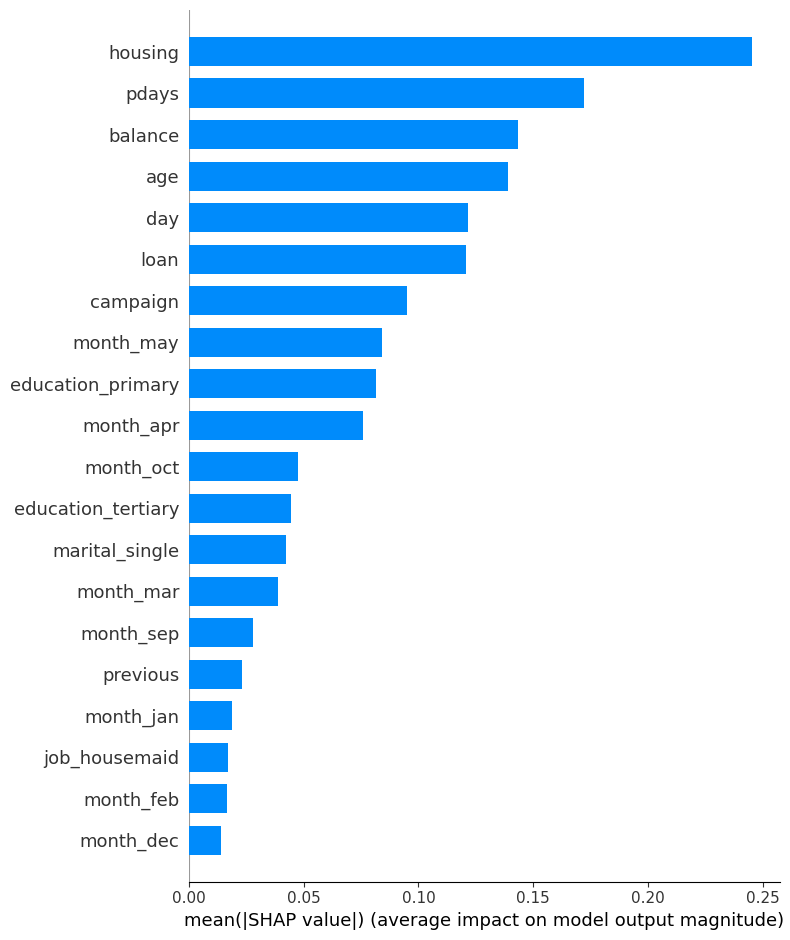

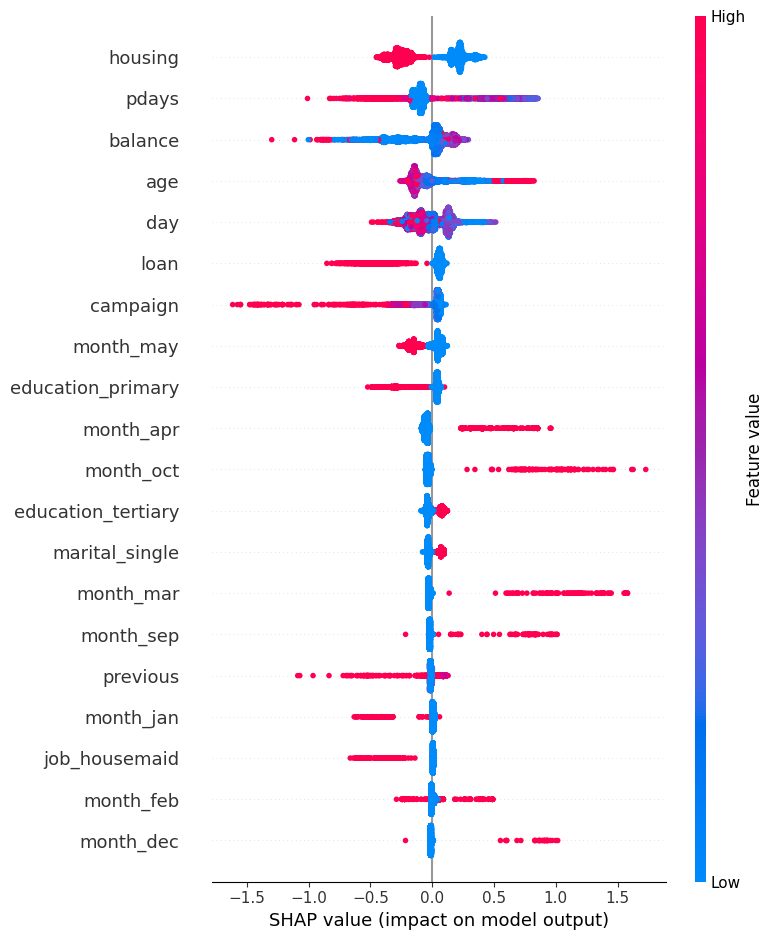

In [32]:
import shap

# Initialize the JS visualization code
shap.initjs()

# Create object that can calculate shap values
explainer = shap.TreeExplainer(gb)

# Calculate Shap values for X_test
shap_values = explainer.shap_values(X_test)

# Plot summary plot using shap values for all features for the first 100 instances
shap.summary_plot(shap_values, X_test.iloc[:100], plot_type="bar")

# Plot summary plot using shap values for all features
shap.summary_plot(shap_values, X_test)



### Other experiments


In [36]:
df = pd.read_csv('Dataset/bank-full.csv', delimiter=';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [98]:
VARS = ['age', 'job', 'marital', 'education', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'campaign', 'poutcome']
TARGET = ['y']
CAT_VARS = ['job','marital','education','contact','month','poutcome']
x = df[VARS]
y = df[TARGET]

x['housing'] = x['housing'].map({'yes': 1, 'no': 0})
x['loan'] = x['loan'].map({'yes': 1, 'no': 0})
y['y'] = y['y'].map({'yes': 1, 'no': 0})

In [99]:
### Split the data into training and testing
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123)

In [100]:
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_validate

model = CatBoostClassifier(random_state=123, cat_features = CAT_VARS, verbose=0)
scores = cross_validate(
    model,
    x_train,
    y_train,
    cv = 5,
    scoring=['roc_auc'],
    return_train_score=True
)

scores

{'fit_time': array([15.74596405, 16.62960696, 14.41784668, 13.15753388, 13.22889304]),
 'score_time': array([0.02586389, 0.02102494, 0.02648807, 0.021806  , 0.01935601]),
 'test_roc_auc': array([0.80034465, 0.80446927, 0.81311914, 0.79235619, 0.80025436]),
 'train_roc_auc': array([0.84777245, 0.84305577, 0.84376707, 0.84861211, 0.8458804 ])}

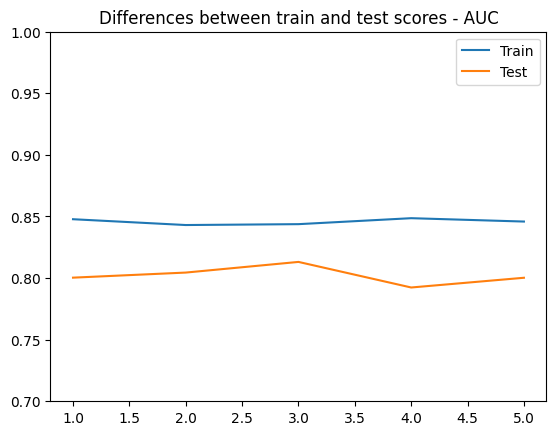

In [101]:
train_scores = scores['train_roc_auc']
test_scores = scores['test_roc_auc']


sns.lineplot(x = range(1,6), y = train_scores, label = 'Train')
sns.lineplot(x = range(1,6), y = test_scores, label = 'Test')
plt.ylim(0.7,1)
plt.title('Differences between train and test scores - AUC')
plt.show()

In [102]:
print('Train score:',train_scores.mean())
print('Test score:', test_scores.mean())
print('Train variation:', train_scores.std())
print('Test variation:', test_scores.std())

Train score: 0.8458175609378223
Test score: 0.8021087222913253
Train variation: 0.002166427456527334
Test variation: 0.006759646824918847


#### Hyperparameter calibration

In [82]:
import optuna

def objective(trial):
    param = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'random_strength': trial.suggest_int('random_strength', 0, 100)
        }
    model = CatBoostClassifier(random_state=123, cat_features = CAT_VARS, verbose=0, **param)
    scores = cross_validate(
        model,
        x_train,
        y_train,
        cv = 5,
        scoring=['roc_auc'],
        return_train_score=True
    )
    mean_auc = scores['test_roc_auc'].mean()
    return mean_auc

In [84]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

[I 2024-02-23 03:02:59,313] A new study created in memory with name: no-name-32544b7e-8639-4cae-b18f-bdac959750e3
[I 2024-02-23 03:03:30,667] Trial 0 finished with value: 0.7990970265019927 and parameters: {'iterations': 430, 'depth': 7, 'learning_rate': 0.038843334028020836, 'random_strength': 9}. Best is trial 0 with value: 0.7990970265019927.
[I 2024-02-23 03:04:07,002] Trial 1 finished with value: 0.7979849401376592 and parameters: {'iterations': 331, 'depth': 8, 'learning_rate': 0.1268668234675348, 'random_strength': 100}. Best is trial 0 with value: 0.7990970265019927.
[I 2024-02-23 03:04:29,266] Trial 2 finished with value: 0.7992150560482648 and parameters: {'iterations': 312, 'depth': 4, 'learning_rate': 0.12212116101983828, 'random_strength': 73}. Best is trial 2 with value: 0.7992150560482648.
[I 2024-02-23 03:04:32,257] Trial 3 finished with value: 0.7584913552414176 and parameters: {'iterations': 125, 'depth': 4, 'learning_rate': 0.04051222434563582, 'random_strength': 73}

In [103]:
best_params = study.best_params
print(best_params)

{'iterations': 692, 'depth': 8, 'learning_rate': 0.034026901540300296, 'random_strength': 30}


In [104]:
model = CatBoostClassifier(random_state=123, cat_features = CAT_VARS, **best_params, verbose=0)
model.fit(x_train, y_train)

#### Finding the best threshold

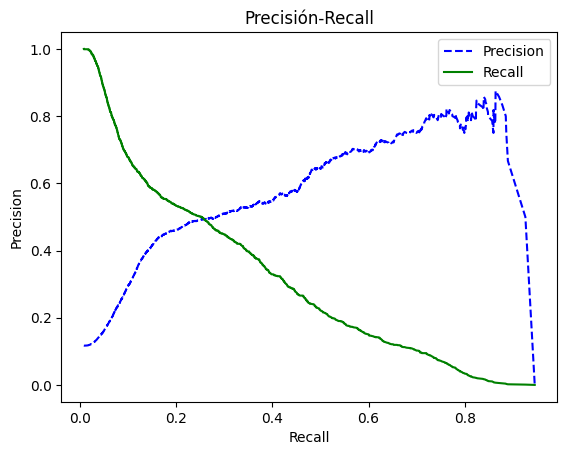

In [105]:
probas = model.predict_proba(x_test)

f.plot_precision_recall(y_test, probas[:,1])


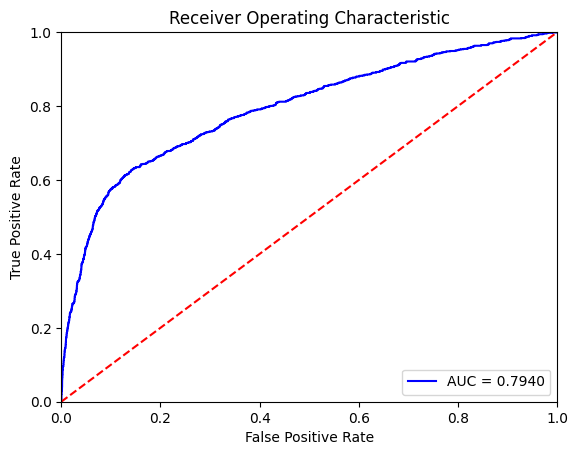

In [107]:
fpr, tpr, thresholds = f.plot_roc_curve(y_test, probas)

In [134]:
### Setting threshold to 0.25

threshold = 0.08
y_pred = np.where(probas[:,1] > threshold, 1, 0)

metrics = f.get_metrics(y_test, y_pred, probas)
metrics

{'accuracy': 0.689372995687272,
 'precision': 0.23630343166767007,
 'recall': 0.7426679280983917,
 'f1': 0.3585293445992236,
 'roc_auc': 0.7940149992856468,
 'confusion_matrix': array([[5449, 2537],
        [ 272,  785]])}

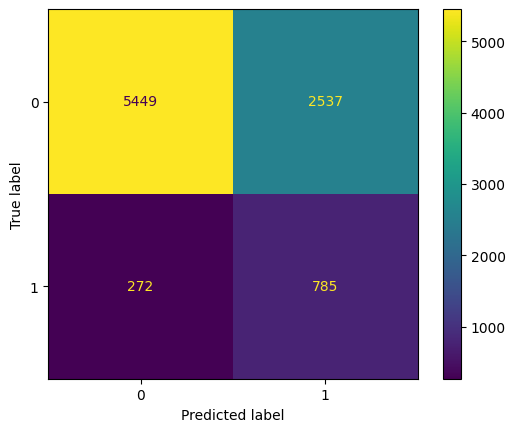

In [135]:
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(metrics['confusion_matrix'])
disp.plot()
plt.show()